In [20]:
import pandas as pd
import numpy as np
import pdfplumber as scrapper
import PyPDF2
from io import StringIO
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Step 1. Importing all items and products

In [2]:
# Identify all items
item_num = 0
products_list = []
item_prod_relations = {}
prod_num_in_items = 0

path = "/Users/jennylee/CFFS-2022-2023"
os.chdir(path)
filepath = glob.glob(os.path.join(os.getcwd(), "notebooks", "data", "AMS", "*.pdf"))

col_list = ["ItemId", "Description", "Qty", "UOM", "PrepId"]
df = pd.DataFrame(columns=col_list)
df

for file in filepath:

    def generate_items(pdf):
        file = open(str(pdf), "rb")
        pdfReader = PyPDF2.PdfFileReader(file)
        pageObj = pdfReader.getPage(0)
        myfile = pageObj.extractText()
        product = myfile.partition('\n')[0]
        products_list.append(product)
        myfile = myfile.split("\n", 4)[4]
        myfile = myfile.splitlines()
        df = pd.read_csv(StringIO("\n". join(myfile)), sep=" ", names=range(20), on_bad_lines="skip", quotechar=None, quoting=3)

        amounts = df.iloc[:, 0:4]
        amounts_col = ["Single", "Double", "Triple", "Half"]
        amounts.columns = amounts_col
        ingredient = df.iloc[:, 5:]
        ingredient["Description"] = ingredient.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        ingredient["Description"] = ingredient["Description"].str.replace("nan","")
        ingredient['Description'] = ingredient['Description'].str.extract('(\d*\.*\d*\s*[A-Z].*$)')
        df = pd.concat([amounts, ingredient["Description"]], axis=1)

        df["ItemId"] = ""

        df[["Amount", "Unit"]] = df["Single"].str.extract(pat=r"(\d+\.?\d*)(.*)")
        ind_num = df[df["Amount"].isnull()].index.tolist()
        min_nan = min(ind_num)
        df = df.iloc[:min_nan]
        df["InventoryGroup"] = ""

        global prod_num_in_items

        df["PrepId"] = "P-" + str(prod_num_in_items)
        prod_num_in_items += 1
        df = df.rename(columns={"Amount": "Qty", "Unit":"UOM"})

        for ind, row in df.iterrows():

            global item_num
            df.loc[ind, "ItemId"] = "I-" + str(item_num)
            item_num += 1

        item_col_list = ["ItemId", "Description", "Qty", "UOM", "PrepId"]
        df = df[item_col_list]

        return df
    
    temp_df = generate_items(file)
    global df
    df = pd.concat([df, temp_df], axis=0)
    
items = df    
print(len(items))
items.head(30)

154


,ItemId,Description,Qty,UOM,PrepId
0,I-0,Radish - Daikon,1000.000,g,P-0
1,I-1,2022.3 Basic Pickling Liqui d,1000.000,g,P-0
0,I-2,NORI KIZAMI BTL,1.000,g,P-1
1,I-3,PORT PORT 2022.3 Double Down Chick e,2.000,PORT,P-1
2,I-4,PATTY PATTY 2022.3 Rice Patty Cake,1.000,PATTY,P-1
3,I-5,Lettuce - Butter,0.050,ea,P-1
4,I-6,TOMATO - 6 X 7 MED,30.000,g,P-1
5,I-7,2022 KFC Sauce,45.000,g,P-1
6,I-8,CUCUMBER LONG ENGLI S,15.000,g,P-1
0,I-9,Tofu MED Firm Sunrise,36.000,lb,P-2


In [3]:
prep_num = 0

def generate_products():
    global products_list
    columns = ["Description"]
    df = pd.DataFrame(products_list, columns=columns)
    df["PrepId"] = ""
    
    for ind, row in df.iterrows():

        global prep_num
        df.loc[ind, "PrepId"] = "P-" + str(prep_num)
        prep_num += 1
    
    df['Description'] = df['Description'].str.replace('^2022.3 ','')
    df['Description'] = df['Description'].str.replace('\s*FLAVOUR LAB \(FLAVLAB\)','')
    prep_col_list = ["PrepId", "Description"]
    df = df[prep_col_list]
    
    return df
    
products = generate_products()
products

,PrepId,Description
0,P-0,Pickled Daikon
1,P-1,Full KFC Double Down
2,P-2,Smoked Tofu Block
3,P-3,Full Aloo Tikki Burger
4,P-4,Pesto Cream
5,P-5,Smoked Paprika Rub
6,P-6,Onion/Garlic/Oil
7,P-7,Marinara SauceCOMMISSARY (COM)
8,P-8,Potato Skins
9,P-9,Cheap Pasta


### Step 1-a. Identifying *Pure Items*
**Pure items**: Items that are independent on its own. These items are NOT used as an ingredient for another product. 

In [4]:
mask = items["Description"].str.contains('2022.3')
masked = items[mask]

pure_df = pd.merge(items, masked, how='outer', indicator='Exist')
pure_df = pure_df.loc[pure_df['Exist'] != 'both']
pure_df = pure_df.drop(["Exist"], axis=1)
pure_df.to_csv("notebooks/data/AMS/preprocessed/pure_items.csv", index=False)
pure_df

,ItemId,Description,Qty,UOM,PrepId
0,I-0,Radish - Daikon,1000.000,g,P-0
2,I-2,NORI KIZAMI BTL,1.000,g,P-1
5,I-5,Lettuce - Butter,0.050,ea,P-1
6,I-6,TOMATO - 6 X 7 MED,30.000,g,P-1
7,I-7,2022 KFC Sauce,45.000,g,P-1
...,...,...,...,...,...
148,I-148,SUGAR GRANULATED FI N,15.000,g,P-25
150,I-150,PFO OIL CANOLA JIB AN T,3000.000,ml,P-27
151,I-151,THYME,50.000,g,P-27
152,I-152,Chicken Flat Thigh s/onknu c,50.000,lb,P-28


Filter out **child items** which are used as items for other products. 

In [5]:
# child_items = masked.copy()
# child_items = child_items.reset_index().drop(["index"], axis=1)
# child_items["OriginId"]= ""
# child_items.to_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv", index=False)

# child_items = pd.read_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv")
# print(child_items["OriginId"].unique().tolist())
# child_items

- `PrepId`: what that item will be used to make.
- `ProdId`: the made product will be used in future to make another product.

In [6]:
# child_items = child_items.drop("PrepId", axis=1)
# child_items = child_items.rename(columns={"OriginId": "PrepId", "PrepId":"ProdId"})
# child_items.to_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv", index=False)

# for ind, row in child_items.iterrows():
#     if pd.isnull(child_items.at[ind,'PrepId']) == True:
#         child_items.loc[ind, "PrepId"] = row["ProdId"]
        
# child_items.to_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv", index=False)

child_items = pd.read_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv")
child_items

,ItemId,Description,Qty,UOM,ProdId,PrepId
0,I-1,2022.3 Basic Pickling Liqui d,1000.00,g,P-0,P-0
1,I-3,PORT PORT 2022.3 Double Down Chick e,2.00,PORT,P-1,P-20
2,I-4,PATTY PATTY 2022.3 Rice Patty Cake,1.00,PATTY,P-1,P-21
3,I-13,2022.3 Mint Chutney,20.00,g,P-3,P-25
4,I-19,PATTY PATTY 2022.3 Aloo Tikki,1.00,PATTY,P-3,P-18
5,I-47,2022.3 Cooked Penne,10.00,oz,P-9,P-9
6,I-48,2022.3 Marinara,6.00,oz,P-9,P-9
7,I-58,2022.3 Thyme Oil,1000.00,g,P-10,P-27
8,I-81,2022.3 Smoked Paprika Ru,30.00,g,P-15,P-5
9,I-96,2022.3 Potato Patty,120.00,g,P-18,P-12


In [7]:
looped_list = []

for ind, row in child_items.iterrows():
    if row["PrepId"] in ['P-20', 'P-18', 'P-15']:
        looped_list.append(row["ProdId"])

looped_list

['P-1', 'P-3', 'P-24']

In [8]:
parent_prod = ["P-3", "P-1", "P-24", "P-22", "P-13", "P-20"] 

Isolate items that are used for **child products**. 

In [9]:
child_id = child_items.dropna(subset=['PrepId'])
child_list = []

# Identify products that are used as used as ingredients for other products.
for item in child_id["PrepId"].unique().tolist():
    if item in child_items["ProdId"].tolist():
        child_list.append(item)
        
# Identify looped-child products and remove from dataframe. 
col_list = ["ItemId", "Description", "Qty", "UOM", "PrepId"]
new_df = pd.DataFrame(columns=col_list)

for item in child_items["PrepId"].unique().tolist():
    for ind, row in items.iterrows():
        if row["PrepId"] == item:
            new_df = new_df.append(pd.Series(row))

new_df = new_df.reset_index()
drop_df = pd.DataFrame(columns=["ItemId", "Description", "Qty", "UOM", "PrepId"])

# Items used for child products 
for ind, row in new_df.iterrows():
    if row["PrepId"] in child_list:
        new_df = new_df.drop(ind)
        drop_df = drop_df.append(row)
        
new_df = new_df.drop(["index"], axis=1)
print("Removed: ", child_list)
print("Kept: ", new_df["PrepId"].unique().tolist())
new_df

Removed:  ['P-0', 'P-20', 'P-18', 'P-9', 'P-15']
Kept:  ['P-21', 'P-25', 'P-27', 'P-5', 'P-12', 'P-28', 'P-2', 'P-17']


,ItemId,Description,Qty,UOM,PrepId
4,I-108,2022.2 Cooked Sushi Rice,1350.000,g,P-21
5,I-109,SHICHIMI TOGARASHI,15.000,g,P-21
6,I-110,PFO OIL CANOLA JIB AN T,100.000,ml,P-21
7,I-138,MINT LEAVES,100.000,g,P-25
8,I-139,H BUNC H BUNC H CILANTRO,3.000,BUNC,P-25
9,I-140,Chaat Masala,10.000,g,P-25
10,I-141,LEMONS 5lb bag,2.000,ea,P-25
11,I-142,GARLIC WHOLE PEELED,30.000,g,P-25
12,I-143,Ginger Fresh,5.000,g,P-25
13,I-144,JALAPENO PEPPER - FR E,30.000,g,P-25


In [10]:
for ind, row in drop_df.iterrows():
    if row["PrepId"] in ["P-0", "P-9"]:
        drop_df = drop_df.drop(ind)
        
drop_df
# drop_df.to_csv("notebooks/data/AMS/preprocessed/Looped_child_df.csv", index=False)

,ItemId,Description,Qty,UOM,PrepId,index
2,I-106,Flour - Fried Chicken Blend,200.000,g,P-20,0.0
3,I-107,LBS LBS 2022.3 Marinated Chicken T,10.000,LBS,P-20,1.0
18,I-96,2022.3 Potato Patty,120.000,g,P-18,0.0
19,I-97,Sabutdana,15.000,g,P-18,1.0
45,I-79,BEAN GARBANZO CHICK,2.840,L,P-15,0.0
46,I-80,PFO OIL CANOLA JIB AN T,100.000,ml,P-15,1.0
47,I-81,2022.3 Smoked Paprika Ru,30.000,g,P-15,2.0


In [11]:
pure_items = pd.read_csv("notebooks/data/AMS/preprocessed/Pure_items_labelled.csv")

# Filter out complicated items
for ind, row in pure_items.iterrows():
    if row["ProdId"] in parent_prod:
        pure_items = pure_items.drop(ind)

---

## Step 2. Merge Dataframes

In [12]:
pure_items = pd.read_csv("notebooks/data/AMS/preprocessed/Labelled_per_Items.csv")
# pure_items = pure_items.drop(["Weight (g)", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)", 
#                               "Total Freshwater Withdrawals (mL)"], axis=1)
pure_items = pure_items.drop("Weight (g)", axis=1)
pure_items = pure_items.rename(columns={"ConvertToQty":"Weight (g)"})
# pure_items = pure_items.rename(columns={"ConvertToQty":"Weight (g)",
#                                        "CO2 Emission (g CO2)": "Total CO2 Emission (g)",
#                                        "Nitrogen Lost (g)": "Total Nitrogen Emission (g)",
#                                        "Water Withdrawals (mL)": "Total Freshwater Withdrawals (mL)"})
pure_items = pure_items[["ConversionId", "PrepId", "Weight (g)", "GHG Emission (g) / 100g", "N lost (g) / 100g", 
                         "Stress-Weighted Water Use (L) / 100g", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)",
                         "Total Freshwater Withdrawals (mL)"]]
pure_items

,ConversionId,PrepId,Weight (g),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL)
0,I-0,P-0,1000.00,30.620000,0.790000,0.990000,306.200000,7.900000,9900.000
1,I-2,P-1,1.00,0.000000,0.000000,0.000943,0.000000,0.000000,1.000
2,I-77,P-14,5000.00,0.000000,0.000000,0.070126,0.000000,0.000000,5000.000
3,I-95,P-17,100.00,0.000000,0.000000,0.017544,0.000000,0.000000,100.000
4,I-6,P-1,30.00,19.618868,0.223585,2.179245,20.796000,0.237000,2310.000
...,...,...,...,...,...,...,...,...,...
132,I-22,P-4,35.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
133,I-50,P-9,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
134,I-74,P-13,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
135,I-43,P-8,24.00,90.752308,1.225846,16.710462,235.956000,3.187200,43447.200


In [13]:
child_prods = pd.read_csv("notebooks/data/AMS/preprocessed/Labelled_per_Child_Items.csv")
child_prods["ConversionId"] = child_prods["ProdId"]
child_items = child_prods[["ConversionId", "PrepId", "Weight (g)", "GHG Emission (g) / 100g", "N lost (g) / 100g", 
                           "Stress-Weighted Water Use (L) / 100g", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)",
                           "Total Freshwater Withdrawals (mL)"]]
child_items

,ConversionId,PrepId,Weight (g),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL)
0,P-0,P-0,1000.000,0.000000,0.000000,0.100000,0.000000,0.000000,1.000000e+03
1,P-9,P-9,907.184,47.578125,0.589063,13.479219,431.621137,5.343881,1.222813e+05
2,P-17,P-24,300.000,0.000000,0.675000,2.022500,0.000000,2.025000,6.067500e+03
3,P-2,P-22,17579.300,175.420000,0.590000,0.660000,30837.608060,103.717870,1.160234e+05
4,P-5,P-15,30.000,937.030000,0.675000,2.490000,281.109000,0.202500,7.470000e+02
5,P-25,P-3,20.000,50.290000,0.790000,8.130000,10.058000,0.158000,1.626000e+03
6,P-18,P-3,135.000,39.700000,0.500000,0.260000,53.595000,0.675000,3.510000e+02
7,P-12,P-18,120.000,39.700000,0.500000,0.260000,47.640000,0.600000,3.120000e+02
8,P-21,P-22,3470.000,126.725000,0.265000,78.745000,4397.357500,9.195500,2.732452e+06
9,P-20,P-1,4735.920,439.960000,11.680000,37.030000,20836.153632,553.155456,1.753711e+06


In [14]:
df = pd.concat([pure_items, child_items], axis = 0)
df

,ConversionId,PrepId,Weight (g),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL)
0,I-0,P-0,1000.00,30.620000,0.790000,0.990000,306.200000,7.900000,9900.000
1,I-2,P-1,1.00,0.000000,0.000000,0.000943,0.000000,0.000000,1.000
2,I-77,P-14,5000.00,0.000000,0.000000,0.070126,0.000000,0.000000,5000.000
3,I-95,P-17,100.00,0.000000,0.000000,0.017544,0.000000,0.000000,100.000
4,I-6,P-1,30.00,19.618868,0.223585,2.179245,20.796000,0.237000,2310.000
...,...,...,...,...,...,...,...,...,...
8,P-21,P-22,3470.00,126.725000,0.265000,78.745000,4397.357500,9.195500,2732451.500
9,P-20,P-1,4735.92,439.960000,11.680000,37.030000,20836.153632,553.155456,1753711.176
10,P-28,P-26,18143.68,219.980000,5.840000,18.515000,39912.467264,1059.590912,3359302.352
11,P-27,P-10,1000.00,315.090000,0.020000,6.750000,3150.900000,0.200000,67500.000


In [15]:
final_df = pd.DataFrame(columns=["ProdId", "Weight (g)", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)",
                                 "Total Freshwater Withdrawals (mL)"])

df = pd.read_csv("notebooks/data/AMS/preprocessed/processed_items.csv")

all_prod = df["PrepId"].unique().tolist()

for prod in all_prod:
    temp_df = df.loc[df["PrepId"] == prod]
    ProdId = prod
    Weight = 0
    total_CO2 = 0
    total_N = 0
    total_Water = 0
    for ind, row in temp_df.iterrows(): 
        Weight += row["Weight (g)"]
        total_CO2 += row["Total CO2 Emission (g)"]
        total_N += row["Total Nitrogen Emission (g)"]
        total_Water += row["Total Freshwater Withdrawals (mL)"]
    info = [ProdId, Weight, total_CO2, total_N, total_Water]
    final_df.loc[len(final_df.index)] = info

final_df

,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL)
0,P-0,2000.00000,306.200000,7.900000,1.090000e+04
1,P-1,4841.92000,20870.952132,553.855206,1.758204e+06
2,P-14,7130.00000,3258.149000,29.606000,8.529370e+05
3,P-17,570.00000,2549.874000,0.519500,1.280640e+05
4,P-3,585.00000,611.573000,6.356500,1.472910e+05
5,P-24,2455.00000,1109.409500,15.009500,1.013190e+05
6,P-7,2860.45265,4804.217219,19.285610,3.514520e+04
7,P-4,14759.00000,83788.800000,355.347000,3.920529e+05
8,P-12,3764.50000,1861.777250,19.131250,1.402925e+05
9,P-13,3301.00000,20947.200000,86.265000,9.030750e+04


In [16]:
def calculate_100g_emissions(df):
    for ind, row in df.iterrows():
        df.loc[ind, "GHG Emission (g) / 100g"] = (row["Total CO2 Emission (g)"] / row["Weight (g)"]) * 100
        df.loc[ind, "N lost (g) / 100g"] = (row["Total Nitrogen Emission (g)"] / row["Weight (g)"]) * 100
        df.loc[ind, "Stress-Weighted Water Use (L) / 100g"] = ((row["Total Freshwater Withdrawals (mL)"] / 1000) / row["Weight (g)"]) * 100
    return df

calculate_100g_emissions(final_df)

,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g
0,P-0,2000.00000,306.200000,7.900000,1.090000e+04,15.310000,0.395000,0.545000
1,P-1,4841.92000,20870.952132,553.855206,1.758204e+06,431.047025,11.438752,36.312130
2,P-14,7130.00000,3258.149000,29.606000,8.529370e+05,45.696339,0.415231,11.962651
3,P-17,570.00000,2549.874000,0.519500,1.280640e+05,447.346316,0.091140,22.467368
4,P-3,585.00000,611.573000,6.356500,1.472910e+05,104.542393,1.086581,25.177949
5,P-24,2455.00000,1109.409500,15.009500,1.013190e+05,45.189796,0.611385,4.127047
6,P-7,2860.45265,4804.217219,19.285610,3.514520e+04,167.953041,0.674215,1.228659
7,P-4,14759.00000,83788.800000,355.347000,3.920529e+05,567.713260,2.407663,2.656365
8,P-12,3764.50000,1861.777250,19.131250,1.402925e+05,49.456163,0.508202,3.726722
9,P-13,3301.00000,20947.200000,86.265000,9.030750e+04,634.571342,2.613299,2.735762


In [17]:
fifty_cutoff = 180.12
overall_baseline = 360.25

GHG_baseline = 381.13
nitrogen_baseline = 4.21
water_baseline = 1501.2

def create_results_all_factors(df):
    df["Combined Label"] = ""

    def calculate_all_factors(ghg, nitrogen, water):
        weighted_ghg = ghg / (3 * GHG_baseline)
        weighted_nitrogen = nitrogen / (3 * nitrogen_baseline)
        weighted_water = water / (3 * water_baseline)
        return weighted_ghg + weighted_nitrogen + weighted_water

    for ind, row in df.iterrows():
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"])

        if label <= 0.5:
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) or (label < 1):
            df.loc[ind, "Combined Label"] = "Yellow"
    return df

df = create_results_all_factors(final_df)
print(len(df))
df

29


,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Combined Label
0,P-0,2000.00000,306.200000,7.900000,1.090000e+04,15.310000,0.395000,0.545000,Green
1,P-1,4841.92000,20870.952132,553.855206,1.758204e+06,431.047025,11.438752,36.312130,Red
2,P-14,7130.00000,3258.149000,29.606000,8.529370e+05,45.696339,0.415231,11.962651,Green
3,P-17,570.00000,2549.874000,0.519500,1.280640e+05,447.346316,0.091140,22.467368,Green
4,P-3,585.00000,611.573000,6.356500,1.472910e+05,104.542393,1.086581,25.177949,Green
5,P-24,2455.00000,1109.409500,15.009500,1.013190e+05,45.189796,0.611385,4.127047,Green
6,P-7,2860.45265,4804.217219,19.285610,3.514520e+04,167.953041,0.674215,1.228659,Green
7,P-4,14759.00000,83788.800000,355.347000,3.920529e+05,567.713260,2.407663,2.656365,Yellow
8,P-12,3764.50000,1861.777250,19.131250,1.402925e+05,49.456163,0.508202,3.726722,Green
9,P-13,3301.00000,20947.200000,86.265000,9.030750e+04,634.571342,2.613299,2.735762,Yellow


In [18]:
looped_menus = ['P-20', 'P-18', 'P-15']
prod_list = ['P-1', 'P-3', 'P-24']

for ind, row in df.iterrows():
    if row["ProdId"] in looped_menus:
        df = df.drop(ind)
        
df

,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Combined Label
0,P-0,2000.00000,306.200000,7.900000,1.090000e+04,15.310000,0.395000,0.545000,Green
1,P-1,4841.92000,20870.952132,553.855206,1.758204e+06,431.047025,11.438752,36.312130,Red
2,P-14,7130.00000,3258.149000,29.606000,8.529370e+05,45.696339,0.415231,11.962651,Green
3,P-17,570.00000,2549.874000,0.519500,1.280640e+05,447.346316,0.091140,22.467368,Green
4,P-3,585.00000,611.573000,6.356500,1.472910e+05,104.542393,1.086581,25.177949,Green
5,P-24,2455.00000,1109.409500,15.009500,1.013190e+05,45.189796,0.611385,4.127047,Green
6,P-7,2860.45265,4804.217219,19.285610,3.514520e+04,167.953041,0.674215,1.228659,Green
7,P-4,14759.00000,83788.800000,355.347000,3.920529e+05,567.713260,2.407663,2.656365,Yellow
8,P-12,3764.50000,1861.777250,19.131250,1.402925e+05,49.456163,0.508202,3.726722,Green
9,P-13,3301.00000,20947.200000,86.265000,9.030750e+04,634.571342,2.613299,2.735762,Yellow


In [19]:
df = df.merge(products, left_on="ProdId", right_on="PrepId")
df = df.drop("PrepId", axis=1)
df_labelled = df[["ProdId", "GHG Emission (g) / 100g", "N lost (g) / 100g", "Stress-Weighted Water Use (L) / 100g",
                 "Combined Label", "Description"]]
df_labelled.to_csv("notebooks/data/AMS/final/Flavour_Lab_Labelled.csv", index=False)
df_labelled.to_excel("notebooks/data/AMS/final/Flavour_Lab_Labelled.xlsx")  
df_labelled

,ProdId,GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Combined Label,Description
0,P-0,15.310000,0.395000,0.545000,Green,Pickled Daikon
1,P-1,431.047025,11.438752,36.312130,Red,Full KFC Double Down
2,P-14,45.696339,0.415231,11.962651,Green,Cooked Bowtie
3,P-17,447.346316,0.091140,22.467368,Green,Sumac Dressing
4,P-3,104.542393,1.086581,25.177949,Green,Full Aloo Tikki Burger
5,P-24,45.189796,0.611385,4.127047,Green,Fattoush Salad
6,P-7,167.953041,0.674215,1.228659,Green,Marinara SauceCOMMISSARY (COM)
7,P-4,567.713260,2.407663,2.656365,Yellow,Pesto Cream
8,P-12,49.456163,0.508202,3.726722,Green,Potato Patty
9,P-13,634.571342,2.613299,2.735762,Yellow,Gochujang Alfredo


---
## Step 3. Summary and Visualizations

In [24]:
df_labelled = df_labelled.rename(columns={"Combined Label": "Combined_Label"})
display(df_labelled.Combined_Label.value_counts())

Green     19
Yellow     5
Red        2
Name: Combined_Label, dtype: int64

In [57]:
df_summary = df_labelled["Combined_Label"].value_counts().to_frame("Label Counts")
df_summary["Percentage"] = (df_summary["Label Counts"] / df_summary["Label Counts"].sum()) * 100
df_summary

,Label Counts,Percentage
Green,19,73.076923
Yellow,5,19.230769
Red,2,7.692308


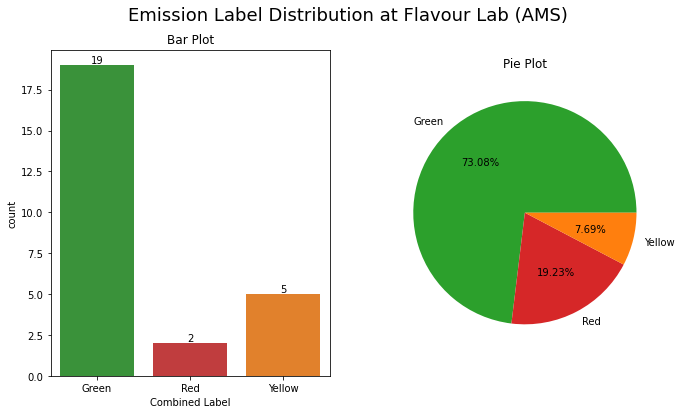

In [52]:
fig, axes = plt.subplots(1,2, figsize=(11,6), sharey=False)

palette = {"Green":"tab:green", "Red":"tab:red", "Yellow":"tab:orange"}
labels = ["Green", "Red", "Yellow"]

# Barplot on the right side
ax1 = sns.countplot(data=df_labelled, x="Combined_Label", ax=axes[0], palette=palette)
ax1.set_xlabel("Combined Label")
ax1.set_title("Bar Plot")

axes[1] = plt.pie(df_labelled["Combined_Label"].value_counts(), 
                  labels=labels,
                  colors=[palette[key] for key in labels],
                  autopct='%1.2f%%',
                  shadow=False)
plt.title("Pie Plot")

for ax in [ax1]:
    for i in ax.containers:
        ax.bar_label(i)

fig.suptitle("Emission Label Distribution at Flavour Lab (AMS)", fontsize=18)
plt.show()